In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as fft
import scipy.signal.windows as windows
import copy
import scipy.integrate as integrate
import scipy.special as sp
import scipy
from uvtools import dspec

In this notebook, I demonstrate the efficacy of the filtering matrix
\begin{equation}
\mathsf{R}^{-1}_{ij} = \mathsf{\delta}_{ij} + \frac{1}{\epsilon}\sum_\alpha e^{-2 \pi I \Delta \nu_{ij} \tau_c^\alpha} \text{Sinc}\left[ 2 \pi \Delta \nu_{ij} \tau_w^\alpha \right]
\end{equation}
If we were to take the DFT of this $\boldsymbol{\mathsf{R}}^{-1}$ matrix across a finite bandwidth, we would get a matrix with diagonals with amplitude of $1/\epsilon$ over delay windows centered at $\tau_c^\alpha$ and, widths of $\tau_w^\alpha$ and convolved by the finite DFT window. Weighting by the inverse of $\boldsymbol{\mathsf{R}}^{-1}$, $\boldsymbol{\mathsf{R}}$, cleans out these windowing artifacts. Below, we apply $\boldsymbol{\mathsf{R}}$ to a simulated autocorrelation. 

**Application to a simulated autocorrelation.**

Now lets test applying $\boldsymbol{\mathsf{R}}$ to a simulated data vector with RFI flags. We will use an explicity non-zero mean data vector, a simulated autocorrelation. First we define some constants for our simulation. 

In [2]:
DF = 100e3 #frequency channel width 
DT = 3600. * 100. #assume integration time of 1000 hours for high dynamic range.
NF = 100 #the number of frequency channels. 
F0 = 150e6 #the center frequency of our simulated autocorrelation. 
filter_half_width = 231e-9
FILTER_FACTOR = 1e-9

Now we calculate our autocorrelation by drawing from a $\Gamma$ distribution with mean $T_\text{sys}(\nu)$ and standard deviation $T_\text{sys}(\nu) / \sqrt{ \Delta \nu \tau }$

In [3]:
freqs = F0 + np.arange(-NF//2,NF//2) * 100e3 #here's a frequency vector. 
tsys = 50. + 60. * (3e8/freqs) ** 2.55 #system temperature
nsamples = int(DF * DT)
autocorr = np.array([np.random.gamma(shape = nsamples, scale = tsys[m]/nsamples) for m in range(NF)]).astype(complex)
noise = autocorr - tsys
weights = np.ones(NF)

Next, we apply our linear filter using the `dspec.dayenu_filter` method. 

In [5]:
autocorr_filter,_ = dspec.dayenu_filter(freqs, autocorr, weights, [1],  filter_centers = [0.], filter_half_widths = [filter_half_width],
                                     filter_factors = [FILTER_FACTOR])


Now lets inspect the results in the Real and Fourier domain. The filtered autocorrelation is very close to the noise residual!

/Users/aewallwi/miniconda3/envs/hera3dev/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


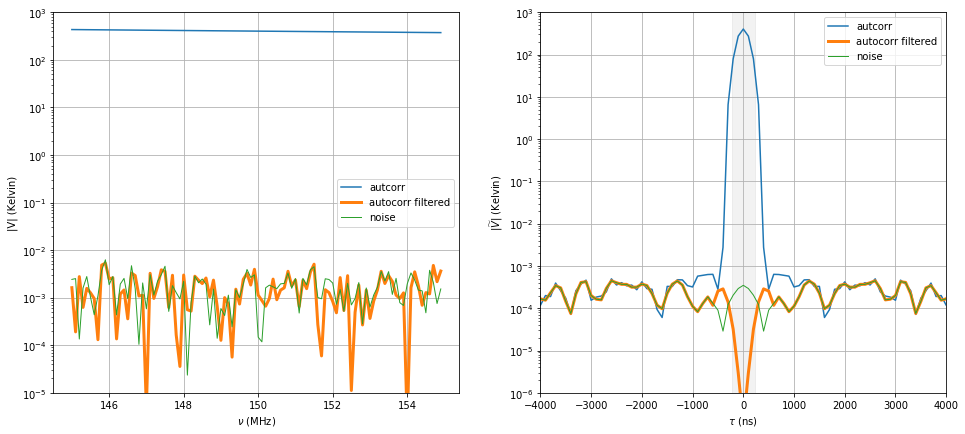

In [6]:
window = windows.get_window('blackmanharris',NF)
window/=window.mean()

dft_noise = fft.fftshift(fft.ifft(fft.fftshift(noise * window)))
dft_auto = fft.fftshift(fft.ifft(fft.ifftshift(autocorr * window)))
dft_auto_filter = fft.fftshift(fft.ifft(fft.ifftshift(autocorr_filter * window)))


fig,axarr = plt.subplots(1,2)
plt.sca(axarr[0])
plt.plot(freqs/1e6,autocorr,label='autcorr')
plt.plot(freqs/1e6, np.abs(autocorr_filter),label='autocorr filtered',lw=3)
plt.plot(freqs/1e6,np.abs(noise),label='noise',lw=1)
plt.grid()
plt.xlabel('$\\nu$ (MHz)')
plt.ylabel('|V| (Kelvin)')
plt.legend(loc='best')
plt.yscale('log')
plt.ylim(1e-5,1e3)


dlys = fft.fftshift(fft.fftfreq(NF,DF))


plt.sca(axarr[1])
plt.plot(dlys*1e9,np.abs(dft_auto),label='autcorr')
plt.plot(dlys*1e9, np.abs(dft_auto_filter),label='autocorr filtered',lw=3)
plt.plot(dlys*1e9,np.abs(dft_noise),label='noise',lw=1)
plt.grid()
plt.xlabel('$\\tau$ (ns)')
plt.ylabel('|$\\widetilde{V}$| (Kelvin)')
plt.legend(loc='best')
plt.yscale('log')
plt.fill_between([-filter_half_width*1e9, filter_half_width*1e9],[1e-10,1e-10],[1e10,1e10],color='grey',alpha=.1)
plt.ylim(1e-6,1e3)
plt.xlim(-4000,4000)
plt.gcf().set_size_inches(16,7)

plt.show()


**Application to a Simulated autocorrelation with RFI Flagging**

Now lets add some RFI flagging gaps and see how the filter does! Here are some flags. 

In [10]:
#generate some random RFI flags.
NRFI = 10
rfi_flags = np.zeros(NF).astype(bool)
rfi_flag_inds = [np.random.randint(NF) for i in range(NRFI)]
rfi_flags[rfi_flag_inds] = True

Construct a flagged autocorrelation and noise. 

In [11]:
#Set flagged channels equal to zero. 
autocorr_flagged = copy.copy(autocorr)
autocorr_flagged[rfi_flags] = 0. 
noise_flagged = copy.copy(noise)
noise_flagged[rfi_flags] = 0. 

Filter the flagged autocorrelation. 

In [12]:
autocorr_filtered_flagged, _ = dspec.dayenu_filter(freqs, autocorr_flagged, (~rfi_flags).astype(float),filter_dimensions=[1],
                                                   filter_centers = [0.], filter_half_widths = [filter_half_width],
                                                   filter_factors = [FILTER_FACTOR])

And plot the results. The Filter is very effective, even in the presence of RFI flagging gaps on the autocorrelation. 

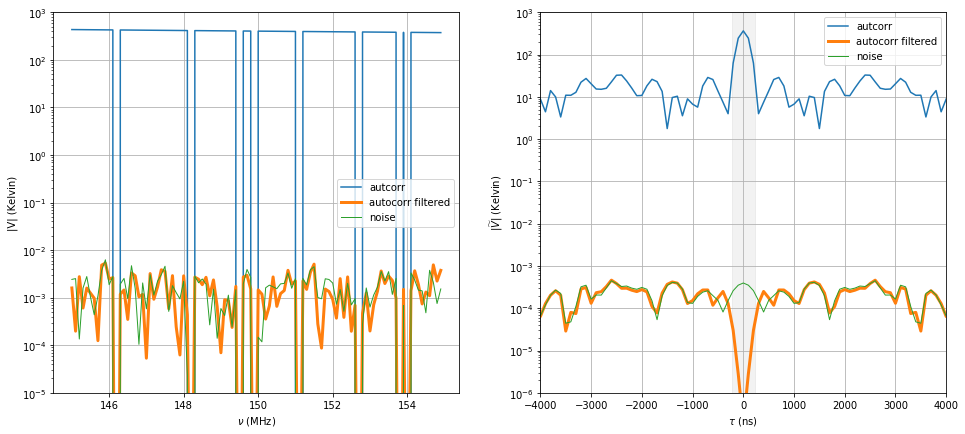

In [13]:

dft_noise_flagged = fft.fftshift(fft.ifft(fft.fftshift(window * noise_flagged)))
dft_auto_flagged = fft.fftshift(fft.ifft(fft.fftshift(window * autocorr_flagged)))
dft_auto_filtered_flagged = fft.fftshift(fft.ifft(fft.fftshift(window * autocorr_filtered_flagged)))



fig,axarr = plt.subplots(1,2)
plt.sca(axarr[0])
plt.plot(freqs/1e6,autocorr_flagged,label='autcorr')
#plt.plot(freqs/1e6,autocorr_tone,label='autocorr + tone')
#plt.plot(freqs/1e6, tone, label='tone')
plt.plot(freqs/1e6, np.abs(autocorr_filtered_flagged),label='autocorr filtered',lw=3)
plt.plot(freqs/1e6,np.abs(noise_flagged),label='noise',lw=1)
plt.grid()
plt.xlabel('$\\nu$ (MHz)')
plt.ylabel('|V| (Kelvin)')
plt.legend(loc='best')
plt.yscale('log')
plt.ylim(1e-5,1e3)


dlys = fft.fftshift(fft.fftfreq(NF,DF))


plt.sca(axarr[1])
plt.plot(dlys*1e9,np.abs(dft_auto_flagged),label='autcorr')
#plt.plot(freqs/1e6,autocorr_tone,label='autocorr + tone')
#plt.plot(freqs/1e6, tone, label='tone')
plt.plot(dlys*1e9, np.abs(dft_auto_filtered_flagged),label='autocorr filtered',lw=3)
plt.plot(dlys*1e9,np.abs(dft_noise_flagged),label='noise',lw=1)
plt.grid()
plt.xlabel('$\\tau$ (ns)')
plt.ylabel('|$\\widetilde{V}$| (Kelvin)')
plt.legend(loc='best')
plt.yscale('log')
plt.fill_between([-filter_half_width*1e9, filter_half_width*1e9],[1e-10,1e-10],[1e10,1e10],color='grey',alpha=.1)
plt.ylim(1e-6,1e3)
plt.xlim(-4000,4000)
plt.gcf().set_size_inches(16,7)


plt.show()


## Why is this it so effective? Comparison with IDFT of a diagonal matrix.

Why is this filter able to isolate and subtract Foregrounds so effecitvely, even when the foregrounds are spread everywhere by window functions when we take a DFT? 

To better understand this, consider that our filter is equivalent to modeling the covariance of our foregrounds through the continuous Fourier transform of a diagonal matrix in the infinite dimensional Fourier continuum.
\begin{equation}
C^\text{lazy,c}(\nu_i, \nu_j) = \epsilon^{-1}\text{Sinc}\left[2 \pi \Delta \nu_{ij} \tau_h\right] = \epsilon^{-1} \int d\tau d\tau^\prime e^{- 2 \pi I (\nu_i \tau - \nu_j \tau^\prime)} \tilde{C}^\text{lazy,c}(\tau, \tau^\prime)
\end{equation}
where $\tilde{C}^\text{lazy,c}(\tau,\tau^\prime) = \Pi_{\tau_h}(\tau) \delta_D(\tau-\tau^\prime)$, where $\tau_{x}(y)$ is the tophat function (integral normalized to unity) with width $x$ of $y$ centered at zero. 
Clearly, the covariance contains contributions from the continuum of modes. When we apply the inverse, $\mathsf{R}^{\text{lazy,c}}$, we numerically determine a finite number of foreground eigenmodes containing the continuum of Fourier modes, that indeed exist in our data, within the horizon, and downweight them from our data vector. 

On the other hand, suppose we tried to use a different model for the covariance where we took the IDFT of a diagonal matrix. This would be 
\begin{equation}
C^\text{lazy,dft}(\nu_i,\nu_j) = \epsilon^{-1} \sum_{mn}e^{-2 \pi I (\nu_i \tau_m - \nu_j \tau_n)}\Pi_{\tau_h}(\tau_m) \delta_{mn} = \sum_m e^{-2 \pi I \tau_m(\nu_i - \nu_j)} \Pi_{\tau_h}(\tau_m) = \sum_m \text{Sinc} \left[2 \pi \tau_h (\Delta \nu_{ij} - m B ) \right]
\end{equation}

Which clearly differs from our lazy covariance choice purely by the fact that it contains a wrap around with periodicity of $B$. The significance of this wrap around is very important. The wrap-around occurs because we are forcing the covariance to **only** contain modes that are periodic over the bandwidth of our measurement $B$, or are harmonics of $1/B$. We could easily write down a visibility in the basis of the DFT covariance matrix, simply by taking their DFT. If our foregrounds were purely composed of harmonics of $B$ (which they are not), then dividing out by DFT modes inside of the wedge would be sufficient to subtract them. However, the foregrounds occupy a continuum of modes and when these aharmonic modes are not compact in the DFT basis since they are given as sinc functions centered at the delay of each source and are not contained within the wedge. A more appropriate basis to encode our foregrounds is therefor one where the eigenvectors also contain anharmonic information. Projected on the DFT basis, they would appear as peaks in delay convolved with sinc functions. I hypothesize that any lazy covariance matrix that contains continuum information within the wedge and vastly downweights it should be sufficient for effective foreground avoidance. This technique will fail if continuum Fourier modes (that are occupied by foregrounds) are missing from the covariance. 


## Verifying that the IDFT covariance is simply the lazy covariance with wrap around. 

I double check that a covariance defined by the inverse DFT is indeed equal to the lazy covariance with only the addition of wrap around. 

In [15]:
def dft_sinc(nf, df, delay_width):
    dlys = np.arange(-nf//2,nf//2) * 1./(nf * df)
    mat_dft = np.zeros(nf)
    mat_dft[np.abs(dlys) <= delay_width] = 1. / 2 / delay_width / df
    mat_dft = np.diag(mat_dft)
    idft_mat = fft.fftshift(np.conj(scipy.linalg.dft(nf).T)) / np.sqrt(nf)
    return np.dot(np.conj(idft_mat.T), np.dot(mat_dft, idft_mat))

Now lets inspect the difference between a matrix derived by taking the inverse DFT from delay space and the matrix that we are using the describe the covariance of our foregrounds (in order to filter them). 

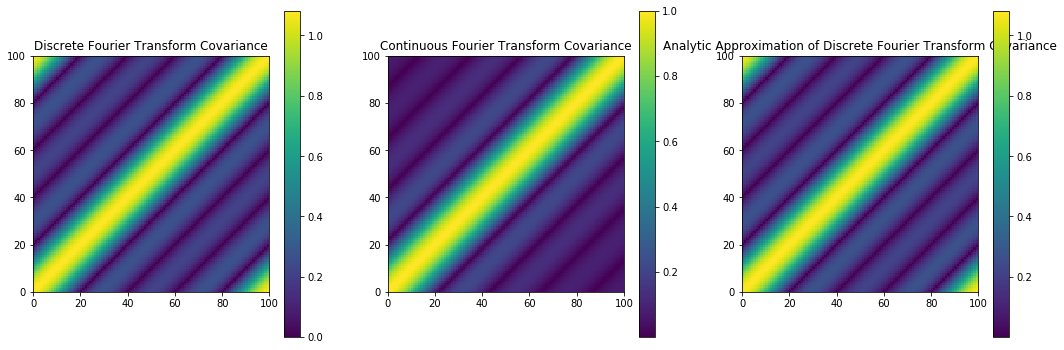

In [17]:

dft_cov = dft_sinc(NF, DF, filter_half_width)
cft_cov = dspec.dayenu_mat_inv(freqs, filter_centers=[0.],
                                        filter_half_widths=[filter_half_width],
                                        filter_factors = [1.],
                                        wrap = False, no_regularization = True)
dft_cov_approx = dspec.dayenu_mat_inv(freqs, filter_centers=[0.],
                                        filter_half_widths=[filter_half_width],
                                        filter_factors = [1.], nwraps = 10000,
                                        wrap = True, no_regularization = True)

fig, axarr = plt.subplots(1, 3)

plt.sca(axarr[0])
plt.pcolor(np.abs(dft_cov))
plt.gca().set_aspect('equal')
plt.colorbar()
plt.title('Discrete Fourier Transform Covariance')



plt.sca(axarr[1])
plt.pcolor(np.abs(cft_cov))
plt.gca().set_aspect('equal')
plt.colorbar()
plt.title('Continuous Fourier Transform Covariance')

plt.sca(axarr[2])
plt.pcolor(np.abs(dft_cov_approx))
plt.gca().set_aspect('equal')
plt.colorbar()
plt.title('Analytic Approximation of Discrete Fourier Transform Covariance')

plt.gcf().set_size_inches(18,6)


The Analytic formula for the IDFT covariance seems to agree well with a direct IDFT of a diagonal matrix. Clearly the Discrete Fourier covariance matrix has a wrap around. **It assumes that foregrounds are periodic over the bandwidth B.** It is not possible to express shapes containing anharmonic tones (that are not harmonics of $1/B$) compactly in the basis. In addition, the central lobe appears narrower.

Here is the absolute difference, it approaches better then one part in $10^5$ of the covariance maximum with 10000 wraps. 

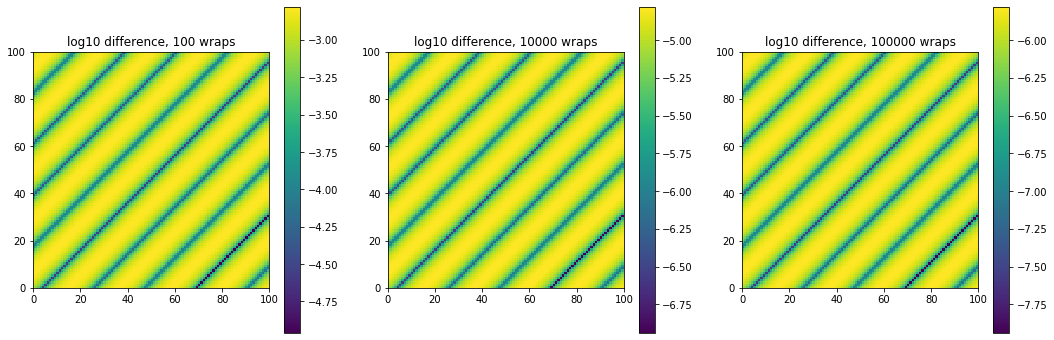

In [18]:
approximations = [ dspec.dayenu_mat_inv(freqs, filter_centers=[0.],
                                        filter_half_widths=[filter_half_width],
                                        filter_factors = [1.], nwraps = n, wrap_interval = 1,
                                        wrap = True, no_regularization = True) for n in [100, 10000, 100000]]


fig, axarr = plt.subplots(1,3)

plt.sca(axarr[0])
plt.pcolor(np.log10(np.abs(dft_cov-approximations[0])))
plt.gca().set_aspect('equal')
plt.title('log10 difference, 100 wraps')
plt.colorbar()

plt.sca(axarr[1])
plt.pcolor(np.log10(np.abs(dft_cov-approximations[1])))
plt.gca().set_aspect('equal')
plt.title('log10 difference, 10000 wraps')
plt.colorbar()

plt.sca(axarr[2])
plt.pcolor(np.log10(np.abs(dft_cov-approximations[2])))
plt.gca().set_aspect('equal')
plt.title('log10 difference, 100000 wraps')
plt.colorbar()

plt.gcf().set_size_inches(18,6)


#### We conclude that the Only Difference between modeling the covariance matrix of our foregrounds with a sinc versus the DFT of a diagonal matrix is the presence of wrap-around features with the interval of the wrap around determining the delay-space resolution of modes contained within the covariance. 

Why is this difference so important? The main reason that the DFT sinc matrix is so bad at isolating foregrounds is that it is only allowed to use modes with delays of $1/B$. However, lets consider the case where the wrap around of the sinc matrix has a periodicity of $2B$. In this case, we have added more modes into the covariance matrix. Unfortunately, I can't seem to find the eigenvectors (which include all of the modes that are missing from the DFT matrix) analytically, however, they do contain the missing modes and we allow the matrix inversion to find them for us.  The clean algorithm attempts to add the modes back iteratively. 

## Efficacy of the filter with decreasing degrees of wrap-around. 

I think its interesting to look at how well this filter performs as a function of periodicity interval with the understanding that as we increase this interval, we are allowing the filter to downweight more and more modes. I'll try filtering with several different wrap intervals: 1B (DFT), 10B, 100B, 1000B, and 10000B versus continuum. 

In [19]:
cov_matrices = [ dspec.dayenu_mat_inv(freqs, filter_centers=[0.],
                                        filter_half_widths=[filter_half_width],
                                        filter_factors = [1.], nwraps = 100000, wrap_interval = wi,
                                        wrap = True, no_regularization = True) for wi in [1, 1.5, 1.9, 2]]
cov_matrices = cov_matrices + [dspec.dayenu_mat_inv(freqs, filter_centers=[0.],
                                        filter_half_widths=[filter_half_width],
                                        filter_factors = [1.], nwraps = 100000, wrap_interval = 1,
                                        wrap = False, no_regularization = True)]

filter_matrices = [np.linalg.pinv(np.identity(NF)+cov_mat/1e-9) for cov_mat in cov_matrices]

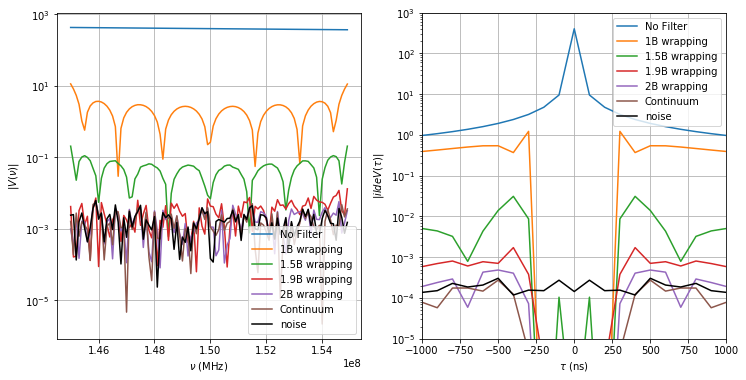

In [20]:
fig, axarr = plt.subplots(1,2)

plt.sca(axarr[0])
f=np.arange(-NF//2,NF//2) * DF + F0
labels = ['1B wrapping', '1.5B wrapping', '1.9B wrapping', '2B wrapping', 'Continuum']
plt.plot(f, np.abs(autocorr), label='No Filter')
for label,filter_mat in zip(labels,filter_matrices):
    auto_filter = np.dot(filter_mat, autocorr) 
    plt.plot(f, np.abs(auto_filter) , label = label)
    
plt.plot(f,np.abs(noise),label='noise',color='k')
plt.yscale('log')
plt.xlabel('$\\nu$ (MHz)')
plt.ylabel('|$V(\\nu)$|')
plt.grid()
plt.legend(loc='best')

plt.sca(axarr[1])

window = windows.get_window('boxcar',NF)
window/=window.mean()
d = np.arange(-NF//2, NF//2) * 1./(NF*DF) * 1e9
labels = ['1B wrapping', '1.5B wrapping', '1.9B wrapping','2B wrapping', 'Continuum']
plt.plot(d, np.abs(fft.fftshift(fft.ifft(fft.fftshift(autocorr)))), label='No Filter')
for label,filter_mat in zip(labels,filter_matrices):
    dft_auto_filter = fft.fftshift(fft.ifft(fft.ifftshift(np.dot(filter_mat, autocorr) * window)))
    plt.plot(d, np.abs(dft_auto_filter) , label = label)

dft_noise = fft.fftshift(fft.ifft(fft.ifftshift(noise * window)))
plt.plot(d,np.abs(dft_noise),label='noise',color='k')
plt.ylim(1e-5,1e3)
plt.xlim(-1000,1000)
plt.yscale('log')
plt.xlabel('$\\tau$ (ns)')
plt.ylabel('|$\tilde{V}(\\tau)$|')
plt.grid()
plt.legend(loc='best')
plt.gcf().set_size_inches(12,6)

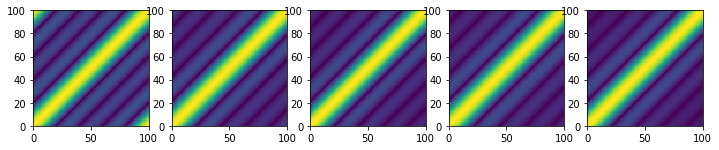

In [21]:
fig,axarr = plt.subplots(1,5)
for m,label,cov in zip(range(len(labels)),labels,cov_matrices):
    plt.sca(axarr[m])
    plt.pcolor(np.abs(cov))
    plt.gca().set_aspect('equal')
plt.gcf().set_size_inches(12, 5)

What is so magical about 2B? This is an area of active research :)

### 2d Filtering

In this section, I demonstrate the two-dimensional filtering feature of `linear_delay_clean` on a 50 meter EW visibility for a single source transiting over an EW baseline. 

In [22]:
TEST_CACHE = {}
OMEGA_EARTH = 2. * np.pi / 3600. / 24.
times = np.linspace(-1800., 1800., NF*2, endpoint = False)
dt = times[1]-times[0]
freqs = np.linspace(145e6, 155e6, NF, endpoint=False)
fg, tg = np.meshgrid(freqs,times)
frates = fft.fftshift(fft.fftfreq(len(times),times[1]-times[0]))
delays = fft.fftshift(fft.fftfreq(len(freqs),freqs[1]-freqs[0]))
dg, frg = np.meshgrid(delays, frates)
signal_2d = 1e5 * np.exp(2j * np.pi * 50. / 3e8 * np.sin(OMEGA_EARTH * tg) * fg)
noise_2d = np.random.randn(2*NF,NF)/np.sqrt(2.)\
+ 1j*np.random.randn(2*NF,NF)/np.sqrt(2.)
data_2d = signal_2d + noise_2d

Here is the unfiltered signal. 

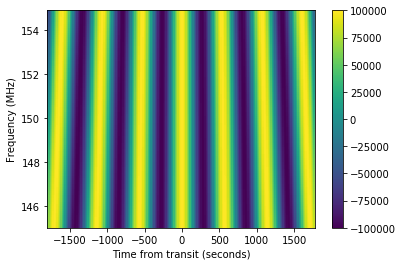

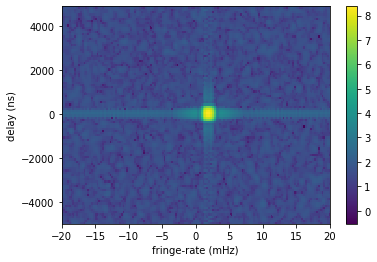

In [23]:
plt.pcolor(tg, fg/1e6, data_2d.real)
plt.xlabel('Time from transit (seconds)')
plt.ylabel('Frequency (MHz)')
plt.colorbar()
plt.show()
window_mat = np.outer(windows.get_window('blackmanharris',2*NF), windows.get_window('blackmanharris',NF))
plt.pcolor(frg*1e3, dg*1e9, np.log10(fft.fftshift(np.abs(fft.fft2(fft.fftshift(window_mat*data_2d))))))
plt.colorbar()
plt.xlabel('fringe-rate (mHz)')
plt.ylabel('delay (ns)')
plt.xlim(-20,20)
plt.show()

Now apply a fringe-rate filter out to 2 mHz.

In [24]:
import imp
imp.reload(dspec)

<module 'uvtools.dspec' from '/Users/aewallwi/miniconda3/envs/hera3dev/lib/python3.7/site-packages/uvtools-0.1.0-py3.7.egg/uvtools/dspec.py'>

In [25]:
filtered_data_fr, _ = dspec.dayenu_filter(times, data_2d, np.ones_like(data_2d),
                        filter_centers = [0.], filter_half_widths = [0.002], filter_factors = [1e-11],
                        filter_dimensions = [0], cache = TEST_CACHE)

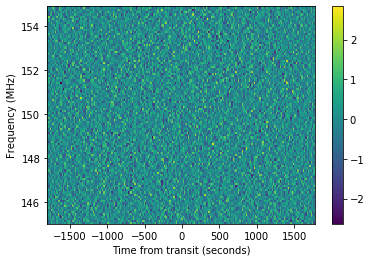

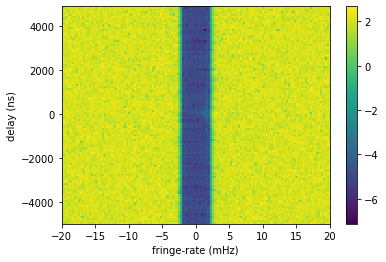

In [26]:
plt.pcolor(tg, fg/1e6, filtered_data_fr.real)
plt.colorbar()
plt.xlabel('Time from transit (seconds)')
plt.ylabel('Frequency (MHz)')
plt.show()
plt.pcolor(frg*1e3, dg*1e9, np.log10(fft.fftshift(np.abs(fft.fft2(fft.fftshift(filtered_data_fr))))))
plt.colorbar()
plt.xlim(-20,20)
plt.xlabel('fringe-rate (mHz)')
plt.ylabel('delay (ns)')
plt.show()

Now clean the same signal with a delay transform instead. 

In [27]:
filtered_data_df, _ = dspec.dayenu_filter(freqs, data_2d, np.ones_like(data_2d),
                    filter_centers = [0.], filter_half_widths = [100e-9], filter_factors = [1e-11],
                    filter_dimensions = [1], cache = TEST_CACHE)

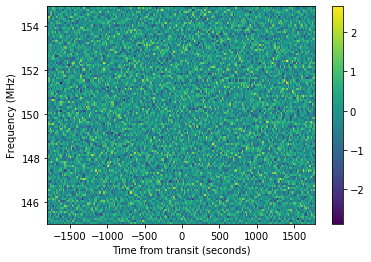

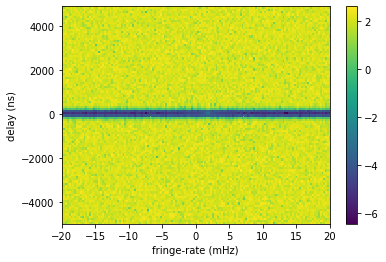

In [28]:
plt.pcolor(tg, fg/1e6, filtered_data_df.real)
plt.colorbar()
plt.xlabel('Time from transit (seconds)')
plt.ylabel('Frequency (MHz)')
plt.show()
plt.pcolor(frg*1e3, dg*1e9, np.log10(fft.fftshift(np.abs(fft.fft2(fft.fftshift(filtered_data_df))))))
plt.colorbar()
plt.xlim(-20,20)
plt.xlabel('fringe-rate (mHz)')
plt.ylabel('delay (ns)')
plt.show()

Perform both fringe-rate and delay clean. 

In [29]:
filtered_data_df_fr, _  = dspec.dayenu_filter([times, freqs], data_2d, np.ones_like(data_2d),
                    filter_centers = [[0.002],[0.]], filter_half_widths = [[0.001],[100e-9]], filter_factors = [[1e-5],[1e-5]],
                    filter_dimensions = [1,0],cache = TEST_CACHE)

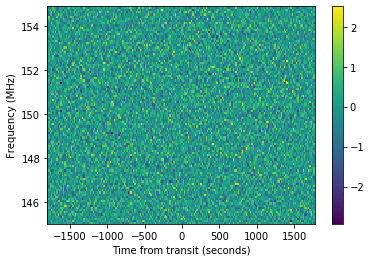

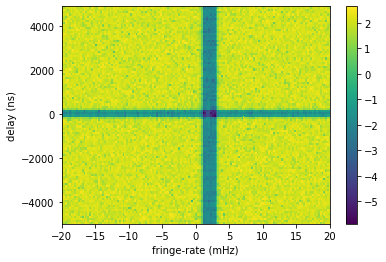

In [30]:
plt.pcolor(tg, fg/1e6, filtered_data_df_fr.real)
plt.colorbar()
plt.xlabel('Time from transit (seconds)')
plt.ylabel('Frequency (MHz)')
plt.show()
plt.pcolor(frg*1e3, dg*1e9, np.log10(fft.fftshift(np.abs(fft.fft2(fft.fftshift(filtered_data_df_fr))))))
plt.colorbar()
plt.xlim(-20,20)
plt.xlabel('fringe-rate (mHz)')
plt.ylabel('delay (ns)')
plt.show()